# VEP normalised scores

In [32]:
from __future__ import annotations
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt


In [1]:
vep_scores = [
    {"id": "SO_0001575", "label": "splice_donor_variant", "score": 1.0},
    {"id": "SO_0001589", "label": "frameshift_variant", "score": 1.0},
    {"id": "SO_0001574", "label": "splice_acceptor_variant", "score": 1.0},
    {"id": "SO_0001587", "label": "stop_gained", "score": 1.0},
    {"id": "SO_0002012", "label": "start_lost", "score": 1.0},
    {"id": "SO_0001578", "label": "stop_lost", "score": 1.0},
    {"id": "SO_0001893", "label": "transcript_ablation", "score": 1.0},
    {"id": "SO_0001822", "label": "inframe_deletion", "score": 0.66},
    {
        "id": "SO_0001818",
        "label": "protein_altering_variant",
        "score": 0.66,
    },
    {"id": "SO_0001821", "label": "inframe_insertion", "score": 0.66},
    {
        "id": "SO_0001787",
        "label": "splice_donor_5th_base_variant",
        "score": 0.66,
    },
    {"id": "SO_0001583", "label": "missense_variant", "score": 0.66},
    {"id": "SO_0001567", "label": "stop_retained_variant", "score": 0.33},
    {"id": "SO_0001630", "label": "splice_region_variant", "score": 0.33},
    {"id": "SO_0002019", "label": "start_retained_variant", "score": 0.33},
    {
        "id": "SO_0002169",
        "label": "splice_polypyrimidine_tract_variant",
        "score": 0.33,
    },
    {
        "id": "SO_0001626",
        "label": "incomplete_terminal_codon_variant",
        "score": 0.33,
    },
    {"id": "SO_0001819", "label": "synonymous_variant", "score": 0.33},
    {
        "id": "SO_0002170",
        "label": "splice_donor_region_variant",
        "score": 0.33,
    },
    {"id": "SO_0001624", "label": "3_prime_UTR_variant", "score": 0.1},
    {"id": "SO_0001623", "label": "5_prime_UTR_variant", "score": 0.1},
    {"id": "SO_0001627", "label": "intron_variant", "score": 0.1},
    {
        "id": "SO_0001619",
        "label": "non_coding_transcript_variant",
        "score": 0.0,
    },
    {"id": "SO_0001580", "label": "coding_sequence_variant", "score": 0.0},
    {"id": "SO_0001632", "label": "downstream_gene_variant", "score": 0.0},
    {"id": "SO_0001631", "label": "upstream_gene_variant", "score": 0.0},
    {
        "id": "SO_0001792",
        "label": "non_coding_transcript_exon_variant",
        "score": 0.0,
    },
    {"id": "SO_0001620", "label": "mature_miRNA_variant", "score": 0.0},
    {"id": "SO_0001060", "label": "intergenic_variant", "score": 0.0},
]


In [ ]:
df = pl.DataFrame(
    data=[(c["id"], c["label"], c["score"]) for c in vep_scores],
    schema=pl.Schema({"sequenceOntologyId": pl.String(), "assessment": pl.String(), "normalisedScore": pl.Float64()}),
    orient="row",
)
df.write_csv("../../data/SO_terms.csv")


/tmp/ipykernel_560427/3858487483.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


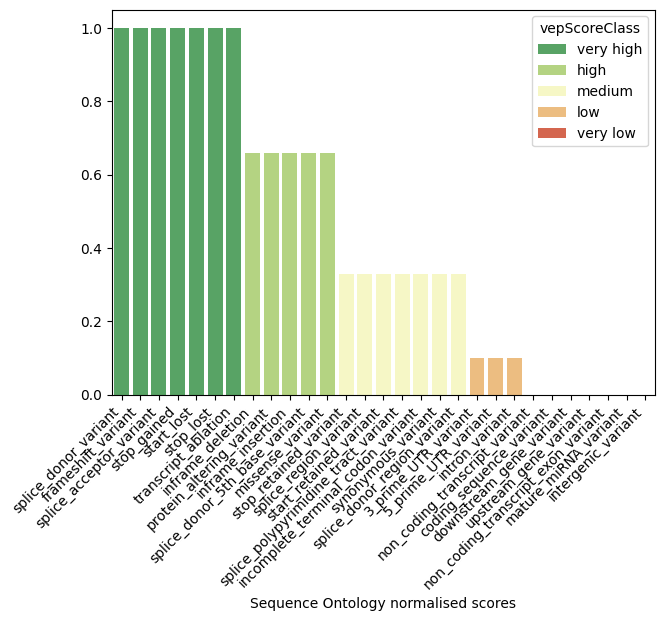

In [35]:
class VepScoringGroup:
    def __init__(self, score: str, label: str):
        assert isinstance(score, (int, float)), "Score must be a number"
        assert isinstance(label, str), "Label must be a string"
        self.score = score
        self.label = label

    def __gt__(self, other: VepScoringGroup) -> bool:
        return self.score > other.score

    def __lt__(self, other: VepScoringGroup) -> bool:
        return self.score < other.score

    def __eq__(self, other: VepScoringGroup) -> bool:
        return self.score == other.score


def classify_by_vep_score(effect: pl.Expr, scores: list[VepScoringGroup] | None = None) -> pl.Expr:
    """Classify the vep score by given scores."""
    if not scores:
        scores = [
            VepScoringGroup(score=0.0, label="very low"),
            VepScoringGroup(score=0.1, label="low"),
            VepScoringGroup(score=0.33, label="medium"),
            VepScoringGroup(score=0.66, label="high"),
            VepScoringGroup(score=1.0, label="very high"),
        ]
    expr = pl.when(False).then(None)
    groups = sorted(scores, reverse=True)
    for group in groups:
        expr = expr.when(effect >= group.score).then(pl.lit(group.label))
    expr = expr.otherwise(pl.lit(None)).alias("vepScoreClass")
    return expr


data = df.with_columns(classify_by_vep_score(pl.col("normalisedScore")))

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
palette = sns.color_palette("RdYlGn", as_cmap=False, n_colors=5)
palette.reverse()
sns.barplot(data=data, x="assessment", y="normalisedScore", ax=ax, hue="vepScoreClass", palette=palette)
# for container in ax.containers:
#     ax.bar_label(container, fmt=lambda x: f"{x}", padding=3, fontsize=8)

ax.set_ylabel("")
ax.set_xlabel("Sequence Ontology normalised scores")
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("right")

fig.show()
